## Sentiment Analysis
- Sentiment Labels:
  1. TextBlob: get polarity and subjectivity scores. Polarity tells us the (+)/(-) sentiment and subjectivity tells us the amount of personal opinion/factual information contained in the text. We'll focus on just polarity for now.
  2. VADAR (Valence Aware Dictionary for Sentiment Reasoning): get pos/neg/neutral sentiment probability scores that add up to 100. There is also a compound score which is the normalized score that calculates the sum of all lexicon ratings and takes values from -1 to 1.
  - Compare results of TextBlob and Vader Sentiment Analysis
- Create some viz
  - sentiment by source
  - top words/bigrams for each sentiment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from ast import literal_eval
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download("stopwords")
stop_words = stopwords.words('english')

from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]

In [ ]:
# setting dir
import os
os.chdir('/content/drive/MyDrive/Projects/Hacks/WWC Hackathon for Social Good/wwcode-hackathon-2022/data')

In [ ]:
df = pd.read_csv("news_cleaned_tokens.csv")
print(df.shape)
df.info()

(9352, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9352 entries, 0 to 9351
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   body            9352 non-null   object
 1   headline        9318 non-null   object
 2   article_name    8664 non-null   object
 3   article_url     9352 non-null   object
 4   date_published  9146 non-null   object
 5   article_length  9352 non-null   int64 
 6   date_uploaded   9352 non-null   object
 7   source          9352 non-null   object
 8   cleaned_tokens  9352 non-null   object
 9   cleaned_text    9352 non-null   object
dtypes: int64(1), object(9)
memory usage: 730.8+ KB


In [ ]:
# use textblob to get the subjectivity and polarity
def get_subjectivity(text):
    """
    Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion 
    and factual information contained in the text. 
    The higher subjectivity means that the text contains personal opinion rather than factual information
    """
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    """Polarity lies between [-1,1]:
       - -1 defines a negative sentiment and 1 defines a positive sentiment. 
       - Negation words reverse the polarity
    """
    return TextBlob(text).sentiment.polarity

In [ ]:
# add subjectivity and polarity to cleaned text
blob_df = df.copy()
blob_df['subjectivity'] = blob_df['body'].apply(get_subjectivity) 
blob_df['polarity'] = blob_df['body'].apply(get_polarity)

print(blob_df['body'].values[0])
print(blob_df['cleaned_text'].values[0])
print(blob_df['subjectivity'].values[0])
print(blob_df['polarity'].values[0])

An exhibition looking at the legacy of colonialism – and the role it played in the birth of climate change – has opened in London. Eleven artists with a personal connection to Africa, the Caribbean and South America have pinpointed environmental change as a racial process, with deep roots in colonial history. Through this collection of artworks, the overlapping crises of environmental damage and colonialism are put under scrutiny. Presenter : Adrian Finighan Guests : Ekow Eshun – Curator “We Are History” Juergen Zimmerer – Professor at the University of Hamburg Stephan Singer – Senior climate science adviser, Climate Action Network International 
exhibition look legacy colonialism role play birth climate change open london eleven artists personal connection africa caribbean south america pinpoint environmental change racial process deep root colonial history collection artwork overlap crisis environmental damage colonialism put scrutiny presenter adrian finighan guests ekow eshun curat

In [ ]:
# add labels to sentiment score (polarity)
blob_df['sentiment'] = ['positive' if score > 0 
              else 'negative' if score < 0 
              else 'neutral' 
              for score in blob_df['polarity']]
blob_df.columns

Index(['body', 'headline', 'article_name', 'article_url', 'date_published',
       'article_length', 'date_uploaded', 'source', 'cleaned_tokens',
       'cleaned_text', 'subjectivity', 'polarity', 'sentiment'],
      dtype='object')

In [ ]:
blob_df['sentiment'].value_counts()

positive    8643
negative     675
neutral       34
Name: sentiment, dtype: int64

In [ ]:
# apply vader sentiment analysis
vader_df = df.copy()
sid = SentimentIntensityAnalyzer()

def get_sentiment(row, **kwargs):
    sentiment_score = sid.polarity_scores(row)
    if kwargs['k'] == 'positive':
      score_meter = round((sentiment_score['pos']), 2)
    elif kwargs['k'] == 'negative':
      score_meter = round((sentiment_score['neg']), 2) 
    elif kwargs['k'] == 'neutral':
      score_meter = round((sentiment_score['neu']), 2)
    elif kwargs['k'] == 'compound':
      score_meter = round((sentiment_score['compound']), 2)
    else:
      print('none')
    return score_meter

#add labels to df
vader_df['positive'] = vader_df['body'].apply(get_sentiment, k='positive')
vader_df['negative'] = vader_df['body'].apply(get_sentiment, k='negative')
vader_df['neutral'] = vader_df['body'].apply(get_sentiment, k='neutral')
vader_df['compound'] = vader_df['body'].apply(get_sentiment, k='compound')

In [ ]:
vader_df[['body', 'cleaned_text', 'positive', 'negative', 'neutral', 'compound']].head(1)

,body,cleaned_text,positive,negative,neutral,compound
0,An exhibition looking at the legacy of colonia...,exhibition look legacy colonialism role play b...,0.03,0.03,0.94,-0.2


In [ ]:
# positive: compound score>=0.05
# neutral: compound score between -0.05 and 0.05
# negative: compound score<=-0.05
vader_df['sentiment']=''
vader_df.loc[vader_df.compound>0.05,'sentiment']='positive'
vader_df.loc[vader_df.compound.between(-0.05, 0.05, inclusive='both'),'sentiment']='neutral'
vader_df.loc[vader_df.compound<-0.05,'sentiment']='negative'

In [ ]:
vader_df['sentiment'].value_counts()

positive    5645
negative    3591
neutral      116
Name: sentiment, dtype: int64

Text(0.5, 0.98, 'Sentiment scores using Vader')

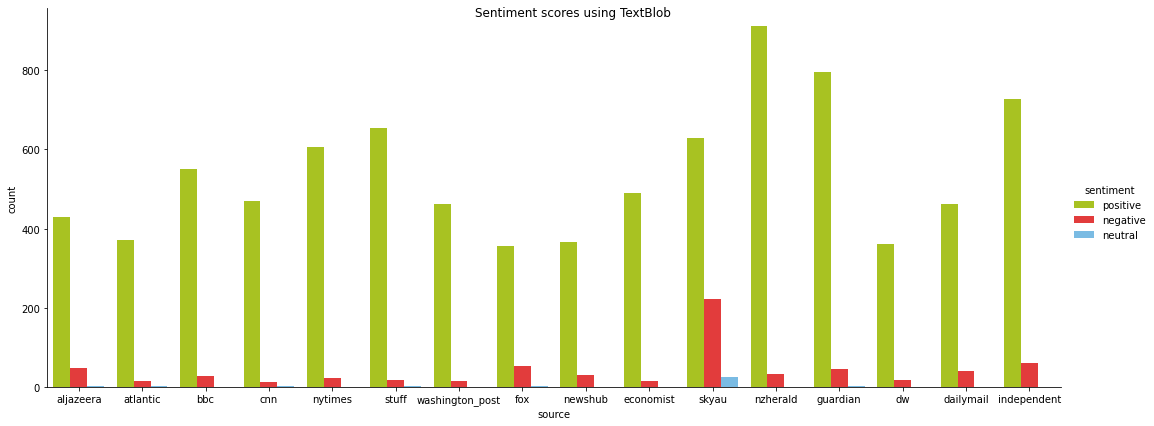

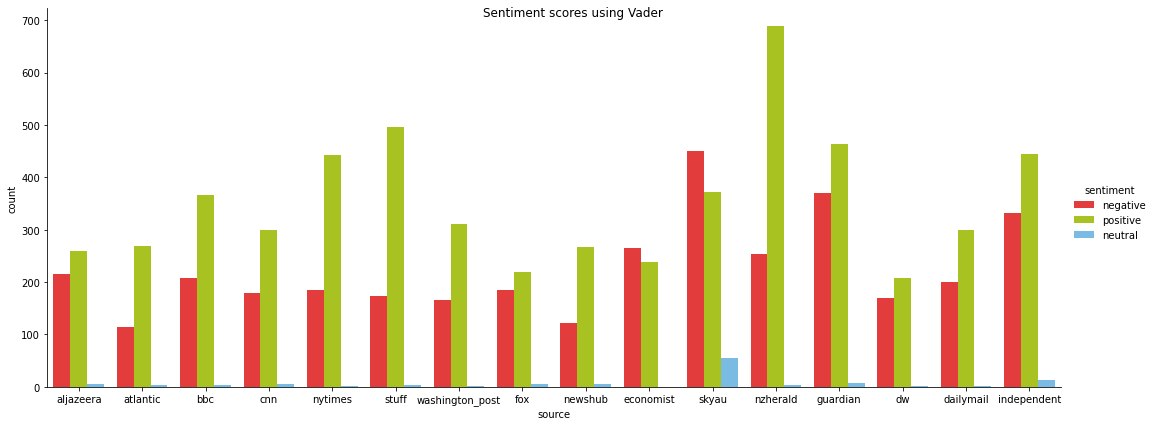

In [ ]:
# plot sentiment scores from using txtblob
blob_src = sns.catplot(x="source", hue="sentiment", 
                    data=blob_df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"}, height=6, aspect=2.5)
blob_src.fig.suptitle('Sentiment scores using TextBlob')

# plot sentiment scores from using vader
vader_src = sns.catplot(x="source", hue="sentiment", 
                    data=vader_df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"}, height=6, aspect=2.5)
vader_src.fig.suptitle('Sentiment scores using Vader')

Most NLP tasks require data cleaning but for sentiment analysis, textblob and vader are case-senitive and care about the punctuations and emojis used so I applied these methods on the raw body text of the climate news data. Textblob classified majority of the articles with a positive sentiment, while Vader classified about 38% of the news with a negative sentiment. Vader was able to separate the texts into postive and negative sentiment. 

In [ ]:
# compare a negative and positive news
display()

In [ ]:
# top words for each sentiment
pos_words = vader_df[vader_df['sentiment'] == 'positive']['cleaned_text']
neg_words = vader_df[vader_df['sentiment'] == 'negative']['cleaned_text']
all_words = pd.concat([pos_words, neg_words])
print(all_words.values.shape)

#create array of pos and neg labels
labels = np.append(np.ones((len(pos_words), 1)), np.zeros((len(neg_words), 1)), axis=0)
print(labels.shape)

(9236,)
(9236, 1)


In [ ]:
def build_freqs(tokens_list, ys):
    """Build frequencies.
    Input:
        tokens: a list of tokens
        ys: an m x 1 array with the sentiment label of each article
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(ys).tolist()

    # looping over all token list in each article 
    # and over all processed words in each token list.
    freqs = {}
    for y, token in zip(yslist, tokens_list):
      #iterate over words 
      splits = token.split()
      for word in splits:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [ ]:
# create freq dict of the word and labels
freqs = build_freqs(all_words, labels)
freqs

{('lifting', 1.0): 24,
 ('u', 1.0): 5281,
 ('sanction', 1.0): 94,
 ('main', 1.0): 884,
 ('focus', 1.0): 2102,
 ('iran', 1.0): 86,
 ('new', 1.0): 17120,
 ('government', 1.0): 8828,
 ('analyst', 1.0): 306,
 ('say', 1.0): 36750,
 ('transition', 1.0): 1511,
 ('green', 1.0): 3360,
 ('economy', 1.0): 3632,
 ('hang', 1.0): 113,
 ('balance', 1.0): 477,
 ('like', 1.0): 7391,
 ('stick', 1.0): 425,
 ('rock', 1.0): 287,
 ('hard', 1.0): 1678,
 ('place', 1.0): 3009,
 ('status', 1.0): 242,
 ('response', 1.0): 1433,
 ('climate', 1.0): 54206,
 ('change', 1.0): 38302,
 ('depend', 1.0): 756,
 ('one', 1.0): 10515,
 ('hand', 1.0): 801,
 ('conservative', 1.0): 820,
 ('prioritise', 1.0): 116,
 ('environment', 1.0): 3427,
 ('international', 1.0): 2841,
 ('community', 1.0): 3016,
 ('treat', 1.0): 301,
 ('country', 1.0): 11727,
 ('pariah', 1.0): 15,
 ('crippling', 1.0): 12,
 ('impose', 1.0): 318,
 ('nuclear', 1.0): 863,
 ('programme', 1.0): 672,
 ('united', 1.0): 4520,
 ('state', 1.0): 7270,
 ('entourage', 1.0)

In [ ]:
# create dictionaries of neg and pos words freq
neg_words_freq = {}
pos_words_freq = {}
for key in freqs.keys():
  word, label = key
  if label == 0:
    neg_words_freq[word] = freqs[key]
  else:
    pos_words_freq[word] = freqs[key]

In [ ]:
neg_df = pd.DataFrame(neg_words_freq.items(), columns=['word', 'neg_count'])
pos_df = pd.DataFrame(pos_words_freq.items(), columns=['word', 'pos_count'])
pos_neg_df = pd.merge(neg_df, pos_df, on='word', how='outer')

In [ ]:
# make neg count as neg values
pos_neg_df['neg_count'] = pos_neg_df['neg_count'] * -1
pos_neg_df.sort_values(by='pos_count', ascending=False).head(50)

,word,neg_count,pos_count
7,climate,-31742.0,54206.0
8,change,-21782.0,38302.0
87,say,-21234.0,36750.0
326,emission,-6025.0,18212.0
167,year,-10163.0,17676.0
210,new,-6922.0,17120.0
174,world,-8304.0,14074.0
108,global,-7575.0,13904.0
169,would,-6412.0,13779.0
325,carbon,-3796.0,12575.0


In [ ]:
# diverging plot of top pos/neg words
# plot the top counts
top_pos_neg_df = pos_neg_df.sort_values(by=['pos_count', 'neg_count'], ascending=False).head(20)
diverging = go.Figure()
colors = {'neg_count': 'red',
          'pos_count': 'green'}
s = pd.Series(colors)

# iterating over the pos/neg columns
for col in top_pos_neg_df.columns[1:]:
  diverging.add_trace(go.Bar(
        x=top_pos_neg_df['word'],
        y=top_pos_neg_df[col],
        #orientation='h',
        name=col,
        marker_color=colors[col],
        hovertemplate="%{x}: %{y}")
  )

  
# layout of the plot
diverging.update_layout(barmode='relative',
                        height=450,
                        width=1000,
                        bargap=0.5) 


In [ ]:
def build_freq_bigrams(bigram_list, labels, corpus):
    """Build frequencies.
    Input:
        bigram_list: a list of bigrams
        labels: an m x 1 array with the sentiment label of each article
            (either 0 or 1)
        corpus: a list of all articles
    Output:
        freqs: a dictionary mapping each (bigram, sentiment) pair to its
        frequency in the entire corpus
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    yslist = np.squeeze(labels).tolist()
    bi_grams_freqs = {}
    for label, text in zip(yslist, corpus):
      for bigram in bigram_list:
        pair = (bigram, label)  
        if pair in bi_grams_freqs:
          bi_grams_freqs[pair] += text.count(bigram)
        else:
            bi_grams_freqs[pair] = 0
    
    return bi_grams_freqs  

In [ ]:
corpus = [words for words in all_words]
vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=300)
bigrams = vect.fit_transform(corpus)
print(bigrams.shape)
bigram_list = vect.get_feature_names_out()
print(bigram_list)

(9236, 295)
['10 year' '15 degree' '1843 take' '20 year' '2015 paris' '21st century'
 '30 year' '50 year' 'accessibility statement' 'accord new'
 'across country' 'across world' 'action climate' 'action take'
 'adapt climate' 'address climate' 'air pollution' 'also say'
 'around world' 'article appear' 'atmospheric administration'
 'average temperature' 'barack obama' 'biden administration'
 'billion dollar' 'billion people' 'burn fossil' 'ca nt' 'call climate'
 'carbon dioxide' 'carbon emission' 'carbon footprint' 'cause climate'
 'change already' 'change also' 'change cause' 'change climate'
 'change could' 'change impact' 'change ipcc' 'change make' 'change may'
 'change need' 'change one' 'change policy' 'change say' 'change would'
 'chief executive' 'clean energy' 'climate accord' 'climate action'
 'climate activist' 'climate agreement' 'climate change'
 'climate conference' 'climate crisis' 'climate emergency'
 'climate impact' 'climate issue' 'climate model' 'climate policy'
 'c

In [ ]:
bigram_freq = build_freq_bigrams(bigram_list, labels, corpus)

In [ ]:
bigram_freq

{('10 year', 0.0): 198,
 ('10 year', 1.0): 501,
 ('15 degree', 0.0): 287,
 ('15 degree', 1.0): 808,
 ('1843 take', 0.0): 265,
 ('1843 take', 1.0): 231,
 ('20 year', 0.0): 285,
 ('20 year', 1.0): 421,
 ('2015 paris', 0.0): 149,
 ('2015 paris', 1.0): 365,
 ('21st century', 0.0): 122,
 ('21st century', 1.0): 223,
 ('30 year', 0.0): 271,
 ('30 year', 1.0): 428,
 ('50 year', 0.0): 238,
 ('50 year', 1.0): 346,
 ('accessibility statement', 0.0): 170,
 ('accessibility statement', 1.0): 208,
 ('accord new', 0.0): 143,
 ('accord new', 1.0): 274,
 ('across country', 0.0): 176,
 ('across country', 1.0): 277,
 ('across world', 0.0): 184,
 ('across world', 1.0): 244,
 ('action climate', 0.0): 401,
 ('action climate', 1.0): 616,
 ('action take', 0.0): 126,
 ('action take', 1.0): 226,
 ('adapt climate', 0.0): 138,
 ('adapt climate', 1.0): 252,
 ('address climate', 0.0): 245,
 ('address climate', 1.0): 594,
 ('air pollution', 0.0): 448,
 ('air pollution', 1.0): 407,
 ('also say', 0.0): 118,
 ('also say

In [ ]:
# create dictionaries of neg and pos words freq
neg_bigram_freq = {}
pos_bigram_freq = {}
for key in bigram_freq.keys():
  bigram, label = key
  if label == 0:
    neg_bigram_freq[bigram] = bigram_freq[key]
  else:
    pos_bigram_freq[bigram] = bigram_freq[key]

neg_bigram_df = pd.DataFrame(neg_bigram_freq.items(), columns=['bigram', 'neg_count'])
pos_bigram_df = pd.DataFrame(pos_bigram_freq.items(), columns=['bigram', 'pos_count'])
bigram_pos_neg_df = pd.merge(neg_bigram_df, pos_bigram_df, on='bigram', how='outer')

# make neg count as neg values
bigram_pos_neg_df['neg_count'] = bigram_pos_neg_df['neg_count'] * -1
bigram_pos_neg_df.sort_values(by='pos_count', ascending=False).head(50)

,bigram,neg_count,pos_count
53,climate change,-17652,29381
179,new zealand,-1351,5400
131,greenhouse gas,-1986,5302
128,global warm,-2923,5092
129,global warming,-2625,4607
118,fossil fuel,-1715,4074
197,per cent,-1509,3868
29,carbon dioxide,-1117,3418
272,united state,-1041,2974
122,gas emission,-1049,2731


In [ ]:
# add pos/neg ratios to df
bigram_df = bigram_pos_neg_df.copy()
bigram_df['pos_perc'] = bigram_df['pos_count'] / abs(bigram_df['neg_count'])
bigram_df['neg_perc'] = abs(bigram_df['neg_count']) / bigram_df['pos_count']
bigram_df

,bigram,neg_count,pos_count,pos_perc,neg_perc
0,10 year,-198,501,2.530303,0.395210
1,15 degree,-287,808,2.815331,0.355198
2,1843 take,-265,231,0.871698,1.147186
3,20 year,-285,421,1.477193,0.676960
4,2015 paris,-149,365,2.449664,0.408219
...,...,...,...,...,...
290,year record,-151,283,1.874172,0.533569
291,year say,-137,256,1.868613,0.535156
292,young people,-403,667,1.655087,0.604198
293,zero carbon,-143,650,4.545455,0.220000


In [ ]:
# diverging plot of top pos/neg bigrams
# plot the top counts
bigram_df_pos = bigram_df.sort_values(by=['pos_perc'], ascending=False).head(20)
diverging = go.Figure()
colors = {'neg_count': 'red',
          'pos_count': 'green'}
s = pd.Series(colors)

# iterating over the pos/neg columns
for col in bigram_df_pos.columns[1:3]:
  diverging.add_trace(go.Bar(
        x=bigram_df_pos['bigram'],
        y=bigram_df_pos[col],
        #orientation='h',
        name=col,
        marker_color=colors[col],
        hovertemplate="%{x}: %{y}")
  )

  
# layout of the plot
diverging.update_layout(barmode='relative',
                        height=450,
                        width=1000,
                        bargap=0.5, 
                        title={'text': "Positive Bigrams"}) 

In [ ]:
bigram_df_neg = bigram_df.sort_values(by=['neg_perc'], ascending=False).head(20)
diverging = go.Figure()
# iterating over the pos/neg columns
for col in bigram_df_neg.columns[1:3]:
  diverging.add_trace(go.Bar(
        x=bigram_df_neg['bigram'],
        y=bigram_df_neg[col],
        #orientation='h',
        name=col,
        marker_color=colors[col],
        hovertemplate="%{x}: %{y}")
  )
  
# layout of the plot
diverging.update_layout(barmode='relative',
                        height=450,
                        width=1000,
                        bargap=0.5, 
                        title={'text': "Negative Bigrams"}) 

Words such as wind solar, clean energy, and renewable energy are 5 times as likely to appear in articles that have a positive sentiment. Articles with a positive sentiment mention more about the methods to prevent climate change and the goal to reduce carbon emissions. Articles with a negative sentiment mention more about the negative effects or harm of climate change, such as the heat waves and natural disasters that are becoming more frequent as climate change worsens.

In [ ]:
# save files
# vader_df.to_csv('vader_sentiment.csv', index=False)
# bigram_df.to_csv('bigram_sentiment_freq.csv', index=False)